# Setup

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [26]:
# Imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Data

In [27]:
class DigitRecognizerDataset(Dataset):
    def __init__(self, dataframe, is_test=False, transform=None):
        self.is_test = is_test
        self.transform = transform
        
        if not self.is_test:
            self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype=torch.long)
            data = dataframe.iloc[:, 1:].values
        else:
            self.labels = None 
            data = dataframe.values
            
        # Features are reshaped to (C, H, W)
        self.features = torch.tensor(data, dtype=torch.float32).view(-1, 1, 28, 28)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx]
        
        # Normalize to [0, 1] range
        image = image / 255.0
        
        # Apply augmentation if provided
        if self.transform:
            image = self.transform(image)
            
        if self.is_test:
            return image
        return image, self.labels[idx]

In [28]:
KAGGLE = True
if KAGGLE:
    train_set_filepath = '/kaggle/input/digit-recognizer/train.csv'
    test_set_filepath = '/kaggle/input/digit-recognizer/test.csv'
else:
    train_set_filepath = os.path.join(os.getcwd(), 'train.csv')
    test_set_filepath = os.path.join(os.getcwd(), 'test.csv')

# Load datasets
base_train_df = pd.read_csv(train_set_filepath)
if os.path.exists(test_set_filepath):
    base_test_df = pd.read_csv(test_set_filepath)
else:
    base_test_df = None

# Only the train set has labels so we need to split that into our real train and test sets
train_df, val_df = train_test_split(base_train_df, test_size=0.2, random_state=42)

train_transforms = transforms.Compose([
    transforms.RandomRotation(10), # Rotate up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Shift and Zoom
])

# Convert to torch datasets
train_set = DigitRecognizerDataset(train_df, is_test=False, transform=train_transforms)
val_set = DigitRecognizerDataset(val_df, is_test=False)
if base_test_df is not None:
    test_set = DigitRecognizerDataset(base_test_df, is_test=True)
else:
    test_set = None

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
if test_set is not None:
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
else:
    test_loader = None

# Model

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Block 1: Input 1x28x28 -> Output 32x14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(0.25)

        # Block 2: Input 32x14x14 -> Output 64x7x7
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(0.25)

        # Fully Connected Classifier
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Flatten and Classify
        x = torch.flatten(x, 1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.drop3(x)
        x = self.fc2(x)
        return x

In [30]:
DEVICE = torch.device('cpu')
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
print(f"Using device: {DEVICE}")

criterion = nn.CrossEntropyLoss()

NUM_MODELS = 5 # Number of models in ensemble
models = []
optimizers = []
schedulers = []

for i in range(NUM_MODELS):
    # Set a unique seed for each model instance
    torch.manual_seed(42 + i) 
    
    model = CNN().to(DEVICE) 
    models.append(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizers.append(optimizer)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    schedulers.append(scheduler)

Using device: cuda


## Train

In [31]:
# Test
def test_model(model):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader)
    print(f'Accuracy: {100 * correct / total:.2f}% | Val Loss: {avg_loss:.4f}')
    return avg_loss # Return this for the scheduler

In [32]:
# Train
EPOCHS = 30
for m_idx, cnn in enumerate(models):
    print(f"Training Model {m_idx + 1}/{len(models)}...")
    optimizer = optimizers[m_idx]
    scheduler = schedulers[m_idx]
    
    for epoch in range(EPOCHS):
        cnn.train() # Set model back to training mode
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step() # needed if using OneCycleLR
    
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    
        # Run validation and get the loss
        current_val_loss = test_model(cnn)
        
        # Step the scheduler based on the validation loss
        scheduler.step(current_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f'End of Epoch {epoch + 1} - Learning Rate: {current_lr}')

    print(f'Finished Training Model {m_idx + 1}')

print('Finished Training')

Training Model 1/5...
[1,   100] loss: 1.182
[1,   200] loss: 0.527
[1,   300] loss: 0.402
[1,   400] loss: 0.306
[1,   500] loss: 0.274
[1,   600] loss: 0.229
[1,   700] loss: 0.235
[1,   800] loss: 0.217
[1,   900] loss: 0.195
[1,  1000] loss: 0.215
Accuracy: 98.62% | Val Loss: 0.0435
End of Epoch 1 - Learning Rate: 0.001
Finished Training Model 1
Training Model 2/5...
[1,   100] loss: 1.177
[1,   200] loss: 0.546
[1,   300] loss: 0.393
[1,   400] loss: 0.317
[1,   500] loss: 0.274
[1,   600] loss: 0.249
[1,   700] loss: 0.229
[1,   800] loss: 0.195
[1,   900] loss: 0.193
[1,  1000] loss: 0.171
Accuracy: 98.61% | Val Loss: 0.0480
End of Epoch 1 - Learning Rate: 0.001
Finished Training Model 2
Training Model 3/5...
[1,   100] loss: 1.172
[1,   200] loss: 0.528
[1,   300] loss: 0.393
[1,   400] loss: 0.315
[1,   500] loss: 0.272
[1,   600] loss: 0.255
[1,   700] loss: 0.224
[1,   800] loss: 0.223
[1,   900] loss: 0.193
[1,  1000] loss: 0.207
Accuracy: 98.74% | Val Loss: 0.0434
End of E

# Submission

In [34]:
if test_loader is not None:
    # Submission
    submission_data = {'ImageId': [], 'Label': []}
    
    # Set all models to eval mode
    for cnn in models:
        cnn.eval()
    
    with torch.no_grad():
        idx = 1
        for images in test_loader:
            images = images.to(DEVICE)
            
            # Initialize an empty tensor to store accumulated predictions
            # Shape: [batch_size, num_classes]
            ensemble_logits = torch.zeros((images.size(0), 10)).to(DEVICE) 
            
            for cnn in models:
                outputs = cnn(images)
                ensemble_logits += outputs # Summing the logits
            
            # Get the index of the max accumulated log-probability
            _, predicted = torch.max(ensemble_logits, 1)
    
            preds = predicted.cpu().numpy()
    
            for p in preds:
                submission_data['ImageId'].append(idx)
                submission_data['Label'].append(p)
                idx += 1
    
    # Save to csv
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved!")

Submission file saved!


## Verification

In [35]:
if submission_df is not None:
    # 1. Check for missing values
    missing_values = submission_df.isnull().sum().sum()
    
    # 2. Check for correct label range (0-9)
    invalid_labels = submission_df[(submission_df['Label'] < 0) | (submission_df['Label'] > 9)]
    
    # 3. Final Verification Report
    print("--- Submission Verification ---")
    print(f"Total Rows: {len(submission_df)}")
    print(f"Missing Values: {missing_values}")
    print(f"Invalid Labels Found: {len(invalid_labels)}")
    print(f"Column Names: {list(submission_df.columns)}")
    
    if len(submission_df) == len(base_test_df) and missing_values == 0 and len(invalid_labels) == 0:
        print("\n✅ Verification Passed! Your file is ready for submission.")
    else:
        print("\n❌ Verification Failed. Please check the counts above.")

--- Submission Verification ---
Total Rows: 28000
Missing Values: 0
Invalid Labels Found: 0
Column Names: ['ImageId', 'Label']

✅ Verification Passed! Your file is ready for submission.


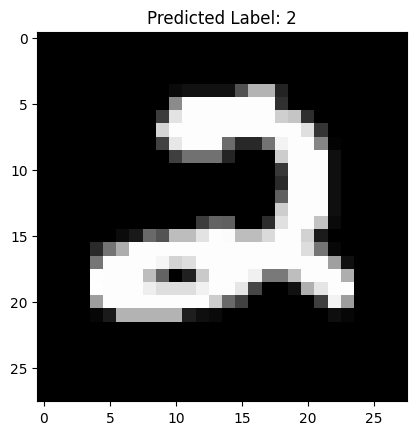

In [38]:
if submission_df is not None:
    # Get one batch from the test loader
    images = next(iter(test_loader))
    outputs = cnn(images.to(DEVICE))
    _, predicted = torch.max(outputs, 1)
    
    # Plot the first image in the batch
    plt.imshow(images[0].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted Label: {predicted[0].item()}')
    plt.show()